- PyCall.jl https://github.com/JuliaPy/PyCall.jl
- pyjulia https://github.com/JuliaPy/pyjulia

# 準備

PyCall.jl をまだインストールしていない場合は、 `Pkg.add("PyCall")` を評価してインストールします。

In [1]:
Pkg.add("PyCall")

INFO: Package PyCall is already installed
INFO: METADATA is out-of-date — you may not have the latest version of PyCall
INFO: Use `Pkg.update()` to get the latest versions of your packages


すでにインストール済みの PyCall.jl を最新版にアップデートする場合は `Pkg.update("PyCall")` を評価します。

In [2]:
Pkg.update("PyCall")

INFO: Updating METADATA...
INFO: Updating PyCall master... 2e5ff6f9 → 0550f890
INFO: Computing changes...
INFO: No packages to install, update or remove


`using PyCall` で PyCall.jl をロードします。

In [3]:
using PyCall

INFO: Recompiling stale cache file /Users/mrkn/.julia/lib/v0.6/PyCall.ji for module PyCall.


`@pyimport` マクロを使うと Python のモジュールをインポートできます。試しに numpy の rand 関数を呼び出して見ましょう。numpy の配列は Julia の Array に変換されます。

In [4]:
@pyimport numpy.random as nr
nr.rand(3,4)

3×4 Array{Float64,2}:
 0.593223  0.278144  0.328856   0.696607
 0.795145  0.146189  0.0624241  0.150557
 0.64174   0.225701  0.913439   0.786279

このように PyCall.jl を使うと Python の機能を Julia から利用できます。ですから、例えば仕事で使いたい機能が Python にはあるけど Julia にはまだ無い場合でも、Julia に移植する時間が無ければ PyCall を使って Python を呼び出してしまえば良いわけです。移植は余裕ができてからやれば OK。

# PyCall.jl の仕組み

PyCall.jl がどのように Julia と Python を橋渡ししているかを簡単に説明します。

`Pkg.add("PyCall")` や `Pkg.build("PyCall")` で PyCall.jl をビルドすると、パス内の `python` コマンド (環境変数 `PYTHON` が指定されている場合はそこに設定されている `python` コマンド) を使用して Python インタープリタの実態である共有ライブラリ `libpython.so` を探します。

`using PyCall` で PyCall.jl をロードすると、ビルド時に探しておいた `libpython.so` を Julia の ffi 機能を利用して動的ロード (`Libdl.dlopen`) します。PyCall は動的ロードした `libpython.so` を使い、[Python インタープリタを他のアプリケーションへ埋め込む](https://docs.python.jp/3/extending/embedding.html)場合と同様のやり方で Julia に埋め込みます。

## Python モジュールのインポート

Python のモジュールは関数 `pyimport` を利用することでインポートできます。例えば、次のコードは `sys` モジュールをインポートします。

In [12]:
sys = pyimport("sys")

PyObject <module 'sys' (built-in)>

関数 `pyimport` はインポートするモジュールの名前を文字列で指定し、結果はインポートされたモジュールです。

一方、上で `numpy.random` モジュールを使った時に利用したマクロ `@pyimport` を利用すると、Python の
```python
import module.name as alias
```
構文と同様の記法が使えます。

## Python のビルトイン関数

Python のビルトイン関数は、関数 `pybuiltin` を使って参照します。

In [19]:
pybuiltin(:len)

PyObject <built-in function len>

In [18]:
pybuiltin(:str)

PyObject <type 'str'>

In [24]:
pybuiltin(:type)

PyObject <type 'type'>

## Python オブジェクトの呼び出し

関数オブジェクトなど `__call__` が定義されているオブジェクトは呼び出し可能です。そのような呼び出し可能なオブジェクトは、`obj(...)` 記法で呼び出せます。

In [33]:
pybuiltin(:object)()

PyObject <object object at 0x124be10d0>

## Python オブジェクトの属性へのアクセス

オブジェクトの属性へは `obj[:attr]` の形式でアクセスします。属性への代入は `obj[:attr] = value` です。

次のコードは、Python での
```python
po = object()
po.__class__
```
と同じです。

In [34]:
po = pybuiltin(:object)()
po[:__class__]

PyObject <type 'object'>

## Python オブジェクトの扱い方

PyCall.jl では、Python オブジェクトのポインタを保持するために PyObject 型のオブジェクトを利用します。これにより、次の図のように Python オブジェクトの構造体のポインタを扱います。

![](pyobject.png)


## 型変換

Python オブジェクトは PyObject 型のオブジェクトに包まれて Julia 側に持ってくるわけですが、全てのオブジェクトをそのようにしてしまうと不便です。PyCall.jl は次の基本的な型については、Julia と Python の間でそれぞれの基本型に相互変換するようになっています。

- 数 (整数、浮動小数点数、複素数、)
- 文字列
- 範囲
- タプル
- 配列
- 辞書
- 多次元数値配列

例えば、`sys.version` は文字列です。これを Julia 側に持ってくると Julia の文字列に自動変換されます。

In [35]:
sys[:version]

"2.7.13 |Continuum Analytics, Inc.| (default, Dec 20 2016, 23:05:08) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]"

同様に、整数である `sys.hexversion` も Julia の整数に自動変換されます。

In [36]:
sys[:hexversion]

34016752

自動変換されないオブジェクトは PyObject 型のオブジェクトのままになります。

例えば、`sys.version_info` の値 (`sys.version_info` 型) は変換されません。

In [39]:
sys[:version_info]

PyObject sys.version_info(major=2, minor=7, micro=13, releaselevel='final', serial=0)

Julia の値を Python の値に変換するには関数 `PyObject` を使います。

PyCall が相互変換を定義している型については対応する Python の型に変換されます。

In [64]:
PyObject(true)

PyObject True

In [65]:
pybuiltin(:type)(PyObject(true))

PyObject <type 'bool'>

In [52]:
PyObject(1)

PyObject 1

In [53]:
pybuiltin(:type)(PyObject(1))

PyObject <type 'int'>

In [54]:
PyObject(1 + 2im)

PyObject (1+2j)

In [57]:
pybuiltin(:type)(PyObject(1 + 2im))

PyObject <type 'complex'>

In [60]:
PyObject("文字列")

PyObject u'\u6587\u5b57\u5217'

In [61]:
pybuiltin(:type)(PyObject("文字列"))

PyObject <type 'unicode'>

In [66]:
PyObject([1, 2, 3, "abc"])

PyObject [1, 2, 3, 'abc']

In [67]:
pybuiltin(:type)(PyObject([1, 2, 3, "abc"]))

PyObject <type 'list'>

In [73]:
PyObject(Dict("a" => 1, "b" => 2, "c" => 3))

PyObject {'a': 1, 'c': 3, 'b': 2}

In [74]:
pybuiltin(:type)(PyObject(Dict("a" => 1, "b" => 2, "c" => 3)))

PyObject <type 'dict'>

PyCall が相互変換を定義していない型については、Python 側では PyCall.jlwrap オブジェクトで Julia オブジェクトのポインタを包む形で Python 側に持っていきます。

In [62]:
PyObject('あ')

PyObject Ptr{PyCall.PyObject_struct} @0x000000012341a210

In [63]:
pybuiltin(:type)(PyObject('あ'))

PyObject <type 'PyCall.jlwrap'>

# PyCall.jl とその周辺ライブラリたち

PyCall.jl は Julia と Python を橋渡しする基本機能を提供してくれます。この基本機能を利用して、Python の主要ライブラリを使いやすくしてくれるラッパーライブラリがいくつか作られています。

- [JuliaPy/Pandas.jl](https://github.com/JuliaPy/Pandas.jl)
- [JuliaPy/PyPlot.jl](https://github.com/JuliaPy/PyPlot.jl)
- [JuliaPy/Seaborn.jl](https://github.com/JuliaPy/Seaborn.jl)
- [cstjean/Sklearn.jl](https://github.com/cstjean/ScikitLearn.jl)


## Pandas を使ってみる

Julia にもデータフレームを提供するライブラリはありますが、現在のところまだ pandas を使う方が色々と便利です。

Pandas.jl ライブラリを利用すると、PyCall.jl の機能を直接利用するより Julia らしく pandas のデータフレームを扱えるようになります。

In [76]:
Pkg.add("Pandas")

INFO: Updating cache of ColorTypes...
INFO: Updating cache of Colors...
INFO: Updating cache of FixedPointNumbers...
INFO: Cloning cache of Lazy from https://github.com/MikeInnes/Lazy.jl.git
INFO: Cloning cache of Pandas from https://github.com/JuliaPy/Pandas.jl.git
INFO: Installing ColorTypes v0.6.1
INFO: Installing Colors v0.8.1
INFO: Installing FixedPointNumbers v0.4.0
INFO: Installing LaTeXStrings v0.2.1
INFO: Installing Lazy v0.11.7
INFO: Installing Pandas v0.5.4
INFO: Installing PyPlot v2.3.2
INFO: Installing Reexport v0.0.3
INFO: Building Conda
INFO: Building PyCall
INFO: PyCall is using /Users/mrkn/.julia/v0.6/Conda/deps/usr/bin/python (Python 2.7.13) at /Users/mrkn/.julia/v0.6/Conda/deps/usr/bin/python, libpython = /Users/mrkn/.julia/v0.6/Conda/deps/usr/lib/libpython2.7
INFO: /Users/mrkn/.julia/v0.6/PyCall/deps/deps.jl has not changed
INFO: /Users/mrkn/.julia/v0.6/PyCall/deps/PYTHON has not changed
INFO: Package database updated


In [77]:
using Pandas

INFO: Precompiling module Pandas.
INFO: Installing matplotlib via the Conda matplotlib package...


Fetching package metadata .........
Solving package specifications: .

Package plan for installation in environment /Users/mrkn/.julia/v0.6/Conda/deps/usr:

The following NEW packages will be INSTALLED:

    cycler:       0.10.0-py27_0    
    freetype:     2.5.5-2          
    libpng:       1.6.27-0         
    matplotlib:   2.0.2-np113py27_0
    pytz:         2017.2-py27_0    
    subprocess32: 3.2.7-py27_0     

libpng-1.6.27- 100% |###############################| Time: 0:00:00  12.37 MB/s
freetype-2.5.5 100% |###############################| Time: 0:00:00  21.79 MB/s
pytz-2017.2-py 100% |###############################| Time: 0:00:00  29.71 MB/s
subprocess32-3 100% |###############################| Time: 0:00:00  32.82 MB/s
cycler-0.10.0- 100% |###############################| Time: 0:00:00  18.21 MB/s
matplotlib-2.0 100% |###############################| Time: 0:00:00  41.07 MB/s                        | Time: 0:00:00  35.37 MB/s.0  60% |##################             | Time: 0

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] include_from_node1(::String) at ./loading.jl:569
 [3] include(::String) at ./sysimg.jl:14
 [4] include_from_node1(::String) at ./loading.jl:569
 [5] include(::String) at ./sysimg.jl:14
 [6] anonymous at ./<missing>:2
 [7] eval(::Module, ::Any) at ./boot.jl:235
 [8] process_options(::Base.JLOptions) at ./client.jl:286
 [9] _start() at ./client.jl:371
while loading /Users/mrkn/.julia/v0.6/Lazy/src/liblazy.jl, in expression starting on line 4
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] include_from_node1(::String) at ./loading.jl:569
 [3] include(::String) at ./sysimg.jl:14
 [4] include_from_node1(::String) at ./loading.jl:569
 [5] include(::String) at ./sysimg.jl:14
 [6] anonymous at ./<missing>:2
 [7] eval(::Module, ::Any) at ./boot.jl:235
 [8] process_options(::Base.JLOptions) at ./client.jl:286
 [9] _start() at ./client.jl:371
while loading /Users/mrkn/.julia/v0.6/Lazy/src/liblazy.jl, i

Fetching package metadata .........
Solving package specifications: .

Package plan for installation in environment /Users/mrkn/.julia/v0.6/Conda/deps/usr:

The following NEW packages will be INSTALLED:

    pandas: 0.20.3-py27_0

pandas-0.20.3- 100% |###############################| Time: 0:00:00  37.04 MB/s


ここでは、[pandas cookbook のこのページ](http://nbviewer.jupyter.org/github/jvns/pandas-cookbook/blob/v0.1/cookbook/Chapter%204%20-%20Find%20out%20on%20which%20weekday%20people%20bike%20the%20most%20with%20groupby%20and%20aggregate.ipynb)の内容の一部を参照し、[pandas cookbook の bikes.csv](https://github.com/jvns/pandas-cookbook/blob/master/data/bikes.csv) を使って pandas のデータフレーム操作の実例を紹介します。以降は、必ず Julia コードを実行するためのコードセルの直前に、対応する Python コードを示します。

まず、データを読み込みます。

```python
bikes = pd.read_csv('bikes.csv', sep=';', encoding='latin1', parse_dates=['Date'], dayfirst=True, index_col='Date')
```

In [89]:
bikes = read_csv("bikes.csv"; sep=";", encoding="latin1", parse_dates=["Date"], dayfirst=true, index_col="Date")

            Berri 1  Brébeuf (données non disponibles)  Côte-Sainte-Catherine  \
Date                                                                            
2012-01-01       35                                NaN                      0   
2012-01-02       83                                NaN                      1   
2012-01-03      135                                NaN                      2   
2012-01-04      144                                NaN                      1   
2012-01-05      197                                NaN                      2   
2012-01-06      146                                NaN                      0   
2012-01-07       98                                NaN                      2   
2012-01-08       95                                NaN                      1   
2012-01-09      244                                NaN                      2   
2012-01-10      397                                NaN                      3   
2012-01-11      273         

プロットしてみましょう。pandas は内部で matplotlib を呼び出して作図をしますが、その結果を Julia 側に持ってくる際に PyPlot.jl が使用されています。

```python
bikes['Berri 1'].plot(figsize=(15, 5))
```

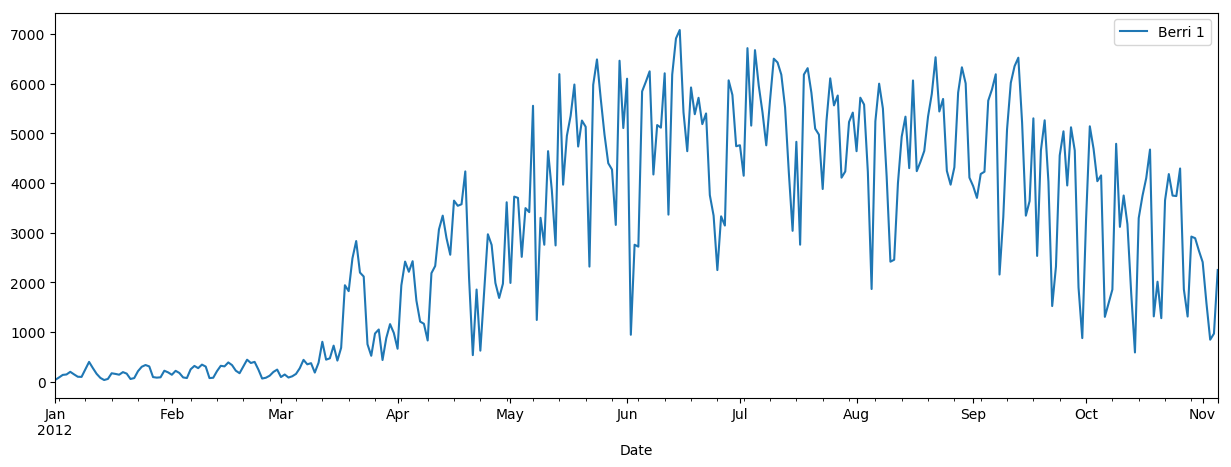

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x13ac2add0>

In [90]:
plot(bikes[["Berri 1"]]; figsize=(15, 5))

データフレームからカラム `Berri 1` を取り出し、最初の5行を取り出して確認します。

```python
berri_bikes = bikes[['Berri 1']]
berri_bikes[:5]
```

In [92]:
berri_bikes = bikes[["Berri 1"]]
berri_bikes[0:5]

            Berri 1
Date               
2012-01-01       35
2012-01-02       83
2012-01-03      135
2012-01-04      144
2012-01-05      197
2012-01-06      146


データをロードする際に `parse_dates=["Date"]` というパラメータを指定してカラム `Date` を日付として解釈し、そして `index_col="Date"` パラメータを指定してカラム `Date` をインデックスにしました。そのため、データフレームのインデックスは DatetimeIndex になっています。したがって、次のようにインデックスの `weekday` 属性を取り出して各行の曜日番号を得ることができます。

```python
berri_bikes.index.weekday
```

In [110]:
index(berri_bikes).pyo[:weekday]

PyObject Int64Index([6, 0, 1, 2, 3, 4, 5, 6, 0, 1,
            ...
            5, 6, 0, 1, 2, 3, 4, 5, 6, 0],
           dtype='int64', name=u'Date', length=310)

曜日番号用のカラムを作ります。

```python
berri_bikes['weekday'] = berri_bikes.index.weekday
berri_bikes[:5]
```

In [117]:
berri_bikes["weekday"] = index(berri_bikes).pyo[:weekday]
berri_bikes[0:5]

            Berri 1  weekday
Date                        
2012-01-01       35        6
2012-01-02       83        0
2012-01-03      135        1
2012-01-04      144        2
2012-01-05      197        3
2012-01-06      146        4


追加した曜日番号カラムの値を利用して、曜日毎に集計します。

```python
weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
weekday_counts
```

In [122]:
weekday_counts = aggregate(groupby(berri_bikes, "weekday"), :sum)
weekday_counts

         Berri 1
weekday         
0         134298
1         135305
2         152972
3         160131
4         141771
5         101578
6          99310


集計結果のインデックスを曜日番号から曜日名に変更します。

```python
weekday_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts
```

In [123]:
index!(weekday_counts, ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
weekday_counts

           Berri 1
Monday      134298
Tuesday     135305
Wednesday   152972
Thursday    160131
Friday      141771
Saturday    101578
Sunday       99310


集計結果を棒グラフで可視化します。

```python
weekday_counts.plot(kind='bar')
```

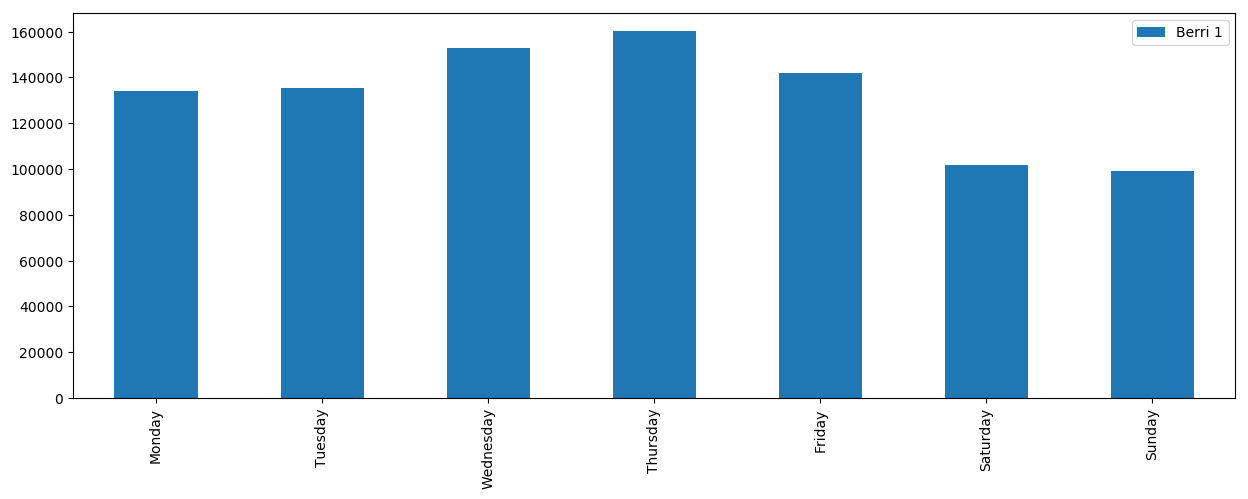

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x13b8848d0>

In [125]:
plot(weekday_counts; kind="bar", figsize=(15, 5))